## Credit Card Type Detection with Support Vector Machine using credit card images 

The aim of this notebook is to predict whether a credit card is Visa card, Master card, or UnionPay card, given their images using a machine algorithm called Support Vector Machine.

In [1]:
# Loading required libraries
%matplotlib inline
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

*Please refer to download_credit_card_image notebook on how to prepare the data.*

Also, you will have to unzip the image data in input folder if you are cloning from the github repository. 

In [2]:
# Load the data
df = pd.read_csv('input/credit-card.csv')
# Since other card types have too little sample, we only use 3 types of cards as our study target
df = df[df.card_type.isin(['Visa', 'MasterCard', 'UnionPay'])] 

In [4]:
# Load the image
from scipy import misc

card_images = list(map(lambda img: misc.imread('input/train_trim_card_image/'+img)[:,:,:3], df.image_name))
# Reshape the array into single dimension
card_image_array = list(map(lambda img: img.ravel(), card_images))
# Transform list of array into matrix
card_image_matrix = np.vstack(card_image_array)

In [5]:
# We have (no. of image) rows and (width x height x RGB Channels) column
card_image_matrix.shape

(127, 15456)

In [6]:
# As usual practice, we split the data into 80% train and 20% test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(card_image_matrix, df.card_type, test_size=0.2, random_state=812)

We will use a simple SVM to predict the card type, noticing that:
- The card type logo appears at the same position for every card, which is bottom right
- Every card image is in the same orientation and layout

In [7]:
# we will first PCA to reduce the matrix dimension, 
# noticing that some feature such as background color can be reduced to low dimensionality since every image has the same layout.
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
pca.fit(X_train)
print(np.cumsum(pca.explained_variance_ratio_)) # We see that 50 components already explained 95% of variablility

[ 0.56753381  0.62054652  0.65833226  0.68632855  0.70924016  0.72794644
  0.74399765  0.75787226  0.77026436  0.78168389  0.79220364  0.80102733
  0.80967317  0.81767656  0.82484884  0.83159657  0.83774259  0.84371907
  0.84958273  0.8551474   0.86048212  0.86527458  0.86992854  0.87440661
  0.87883415  0.88309853  0.8872395   0.8911886   0.89501664  0.89874909
  0.90233317  0.90583257  0.90915116  0.9123947   0.91547697  0.91849496
  0.9214572   0.92435094  0.92700329  0.92955213  0.93200016  0.93441265
  0.93672361  0.93901496  0.94123818  0.94336117  0.94541861  0.94743397
  0.94936528  0.95124228]


In [8]:
# Next we transform the original train and test data into low dimension (50) data
X_train_reduced = pca.transform(X_train)
X_test_reduced = pca.transform(X_test)

In [9]:
# Now, Here we go the most exciting part: Multiclass SVM with linear kernel
from sklearn.svm import SVC
clf = SVC(kernel ='linear', max_iter=10000)
clf.fit(X_train_reduced, y_train) 
clf.score(X_train_reduced, y_train) # It predict perfectly on training set!

1.0

In [10]:
clf.score(X_test_reduced, y_test) # With good cv score.

0.92307692307692313

Now, we can see that our simple model can predict 92% correctly! (compared to 33% for random guessing and ~50% for most frequent card type.)

Let see which image cannot be predicted correctly to investigate the weakness of our model.

In [11]:
prediction = pd.Series(clf.predict(X_test_reduced), index = y_test.index, name='prediction')
df_prediction = pd.concat((df, prediction), axis=1, join='inner')
df_prediction_wrong = df_prediction.loc[lambda df:df.card_type!=df.prediction, :]
df_prediction_wrong

,card_type,image_name,name,prediction
117,UnionPay,icbcSuningUnionPay.jpg,Suning UnionPay Dual Currency Platinum Card,Visa
66,MasterCard,citiPrestige.jpg,Citi Prestige Card,Visa


Suning UnionPay Dual Currency Platinum Card
Citi Prestige Card


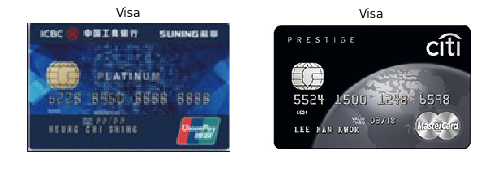

In [13]:
num_wrong = len(df_prediction_wrong.index)
plt.figure(figsize=(8,3))
for i in range(num_wrong):
    print(df_prediction_wrong.name.values[i])
    plt.subplot(1,num_wrong,i+1).set_title(df_prediction_wrong['prediction'].iloc[0])
    plt.imshow(misc.imread('input/train_raw_card_image/'+df_prediction_wrong.image_name.values[i]))
    plt.axis('off')


The reason for the incorrect prediction could be the low resolution of the image or unusual colour of the MasterCard logo.

Lastly, I download some credit card images from other site to see if we can predict the card type correctly

In [14]:
# Function to predict any other single image
def predict_credit_card_type(img_file):
    img=misc.imread(img_file)[:,:,:3]
    img = misc.imresize(img, (56, 92, 3)).ravel()
    img = np.reshape(img, (1, -1))
    img = pca.transform(img)
    return clf.predict(img)

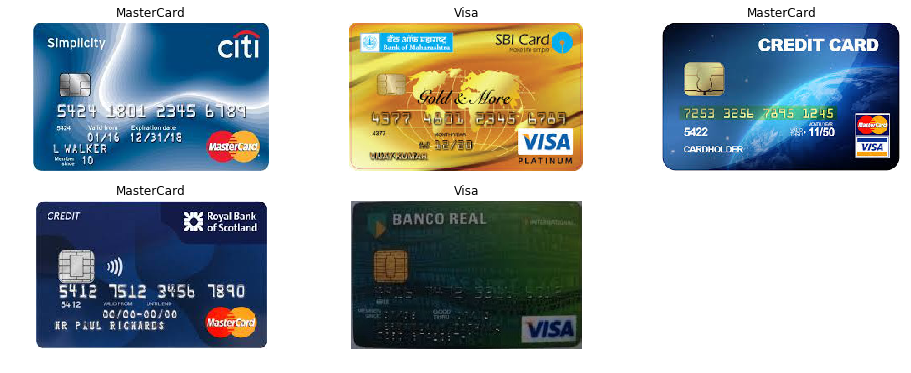

In [15]:
test_images = ['input/test_card_image/'+x for x in ['master-card.jpg', 'visa.jpg','mix.jpg', 'master-card-2.jpg', 'test.jpg']]
num_test_images = len(test_images)
plt.figure(figsize=(16,6))
for i in range(num_test_images):
    plt.subplot(2,num_test_images//2+1,i+1).set_title(predict_credit_card_type(test_images[i])[0])
    plt.imshow(misc.imread(test_images[i]))
    plt.axis('off')

To conclude, our simple SVM provided a fair enough prediction. However, please note that most of these success is due to the consistency of the card structure. In fact, if the card type logo is on other position, or we have different size of credit card, we may have have to use more advance model like convolution neural network.